In [1]:
!pip install transformers sentencepiece datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer, T5ForConditionalGeneration
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
sns.set_style("whitegrid")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [5]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_clean.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer,answer_start
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...,9
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...,9
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю...",2551
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...,4573
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери...",9
...,...,...,...,...
1108,есть ли у вас информация об измерении темпера...,измерение температуры тела может помочь обнару...,измерение температуры тела может помочь обнар...,-1
1109,что такое дефицит аденозинмонофосфатдезаминаз...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит аденозинмонофосфат амф дезаминазы это ...,12
1110,сколько людей страдают от дефицита аденозинмо...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит амфдезаминазы является одним из наибол...,174
1111,"каковы генетические изменения, связанные с де...",дефицит аденозинмонофосфатдезаминазы амф это ...,мутации в гене ampd1 вызывают дефицит ampдезам...,1495


<Axes: ylabel='Count'>

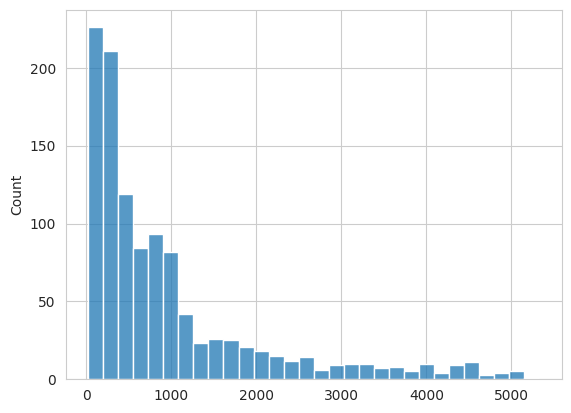

In [6]:
# Distribution of answer lengths
answer_len_lst = [len(answer) for answer in data.answer]

sns.histplot(data=answer_len_lst)

# Let's summarize the answers that are longer than 500

## Load the Model

In [7]:
def gen_batch(inputs, batch_size):
    batch_start = 0
    while batch_start < len(inputs):
        yield inputs.iloc[batch_start: batch_start + batch_size]
        batch_start += batch_size

In [8]:
def predict(
    model_name,
    data,
    max_source_tokens_count=400,
    max_target_tokens_count=128,
    batch_size=64
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).half().to(device)

    #predictions = []
    for batch in tqdm(gen_batch(data, batch_size)):
        texts = [r for r in batch.answer]
        input_ids = tokenizer(
            texts,
            add_special_tokens=True,
            max_length=max_source_tokens_count,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"].to(device)

        output_ids = model.generate(
            input_ids=input_ids,
            max_length=max_target_tokens_count,
            no_repeat_ngram_size=3,
            early_stopping=True,
            num_beams=2
        )
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        questions = [q for q in batch.question]
        contexts = [c for c in batch.context]

        #predictions.extend(summaries)
        with open(PATH + '/data/MedQuAD_answers_sum_128.csv', "a") as w:
            for i in range(len(summaries)):
                w.write(f"{questions[i]}\t{contexts[i]}\t{summaries[i]}\n")

In [9]:
predict("IlyaGusev/rut5_base_sum_gazeta", data)

tokenizer_config.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/828k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/977M [00:00<?, ?B/s]

18it [04:05, 13.65s/it]
